In [1]:
# Standard Libraries


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sc
import scipy.stats as ss


In [2]:
# Plot settings


dark = True
if dark:
    sns.set_style('darkgrid')
    plt.rc("xtick", labelsize=16) # , top=True, direction="in"
    plt.rc("ytick", labelsize=16) # , right=True, direction="in"
else:
    plt.rc("xtick", labelsize=16, top=True, direction="in")
    plt.rc("ytick", labelsize=16, right=True, direction="in")
plt.rc("axes", labelsize=18)
plt.rc("axes", titlesize=20)
plt.rc("legend", fontsize=16)
plt.rc("figure", figsize=(7, 5), titlesize=18)

In [3]:
# Functions


def make_ax(data, x, y, xlabel = 'x', ylabel = 'y', title = 'Title', figsize = (10, 10), label = None, c='black'):
    # Make fig and ax
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Plot data
    ax.plot(data[x], data[y], label=label, color=c, alpha=1/2)

    # Set title and axis labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Return fig and ax
    return fig, ax


def plot_ax(ax, legend = False, grid = False, save = False, filename = 'default.pdf'):
    if grid:
        ax.grid()
    if legend:
        ax.legend(facecolor='white', edgecolor='black', shadow=True)
    if save:
        plt.savefig(filename)
    plt.show()


def load_data(name='Argon1', max=100000):
    data = pd.DataFrame({'Wavelength': [], 'Absorbance': []})
    with open(f'../Data/Grafer_forsoeg_4_labdag2/{name}.txt', 'r') as file:
        current_line_nr = 0
        count = 0
        current_line = file.readline()
        while current_line != '':
            if (current_line_nr < max and 14 <= current_line_nr):
                try:
                    data.loc[count] = [float(x.replace(',', '.')) for i, x in enumerate(current_line.split()) if i < 2]
                    count += 1
                except:
                    pass
            current_line_nr += 1
            current_line = file.readline()
    return data


def find_split_xs(data, x, y):
    max_value = data[y].max()
    threshold = max_value/10
    cutted_data = data[data[y] > threshold]
    splitted_data_xs = []
    previous_x = 0
    for i, _x in enumerate(cutted_data[x]):
        if i > 0:
            if _x - previous_x > 2:
                splitted_data_xs.append(_x)
        previous_x = _x
    return splitted_data_xs


def split_data_on_xs(data, x, y, xs):
    new_data = []
    if len(xs) == 1:
        new_data.append(data[data[x] < xs[0]])
        new_data.append(data[data[x] > xs[0]])
    else:
        for i, _x in enumerate(xs):
            if i == 0:
                new_data.append(data[data[x] < _x])
            elif i == len(xs)-1:
                new_data.append(data[data[x] > _x])
            else:
                new_data.append(data.loc[(data[x] < _x) & (xs[i-1] < data[x])])
    return new_data


def find_peaks(data, x, y):
    peaks = pd.DataFrame({x: [], y: []})
    for i, d in enumerate(data):
        max_y = d[y].max()
        peaks = peaks.append(d.loc[d[y] == max_y], ignore_index=True)
    return peaks


def find_emission_spectrum_lines(data, x, y):
    # Find the wavelength values that seperates different peaks in intensity (result is a list)
    splitted_data_xs = find_split_xs(data=data, x=x, y=y)
    
    # Split data according to those wavelength values (result is a list of dataframes)
    splitted_data = split_data_on_xs(data=data, x=x, y=y, xs=splitted_data_xs)
    
    # Find peaks in pairs (Wavelength, Intensity) for each data frame in splitted_data (result is a dataframe)
    peaks = find_peaks(data=splitted_data, x=x, y=y)
    
    return peaks

def smooth_graph(data, threshold):
    df = pd.DataFrame({'Wavelength': [], 'Absorbance': []})
    
    ws = []
    ab = []
    for i in range(len(data)):
        ws_temp = []
        ab_temp = []
        count = 0
        for obs in data.to_numpy():
            if count == threshold:
                ws.append(np.mean(ws_temp))
                ab.append(np.mean(ab_temp))
                ws_temp = []
                ab_temp = []
                count = 0
            else:
                ws_temp.append(obs[0])
                ab_temp.append(obs[1])
                count += 1
    
    df['Wavelength'] = ws
    df['Absorbance'] = ab
    
    return df

def ab_max(df):
    
    index = 0
    min_dist = 0
    for i, data in enumerate(df.to_numpy()):
        if i == 0:
            min_dist = abs(lambda_max - data[0])
        else:
            dist = abs(lambda_max - data[0])
            if dist < min_dist:
                min_dist = dist
                index = i
    val = df['Absorbance'][index]
    return val

In [4]:
# Variables


names_b = ['B1', 'B2', 'B3', 'B4']
names_r = ['R1', 'R2', 'R3', 'R4']
names_g = ['G1', 'G2', 'G3', 'G4']
names = [names_b, names_r, names_g]
name = 'B1'
x = 'Wavelength'
y = 'Absorbance'

In [5]:
# Load csv fra en ydre mappe '..' går en mappe tilbage og '/Data' går ind i den ydre mappe Data


dfs_b = {}
dfs_r = {}
dfs_g = {}
for name in names:
    for concentration in name:
        df = load_data(name=concentration)
        if concentration[0] == 'B':
            dfs_b[concentration] = df
        elif concentration[0] == 'R':
            dfs_r[concentration] = df
        else:
            dfs_g[concentration] = df

In [6]:
# Visualiser dataframe


dfs_b['B1'].head()

,Wavelength,Absorbance
0,187.642,-1.60
1,188.109,-1.60
2,188.576,-1.60
3,189.043,0.31
4,189.510,0.03


In [7]:
for name in names_b:
    dfs_b[name].drop(dfs_b[name].loc[dfs_b[name]['Wavelength']<500].index, inplace=True)
    dfs_b[name].drop(dfs_b[name].loc[dfs_b[name]['Wavelength']>900].index, inplace=True)

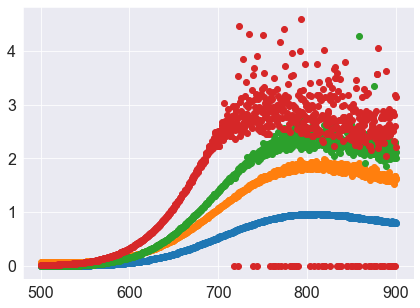

In [8]:
fig, ax = plt.subplots()
ax.scatter(dfs_b['B1']['Wavelength'],dfs_b['B1']['Absorbance'])
ax.scatter(dfs_b['B2']['Wavelength'],dfs_b['B2']['Absorbance'])
ax.scatter(dfs_b['B3']['Wavelength'],dfs_b['B3']['Absorbance'])
ax.scatter(dfs_b['B4']['Wavelength'],dfs_b['B4']['Absorbance'])
plt.show()

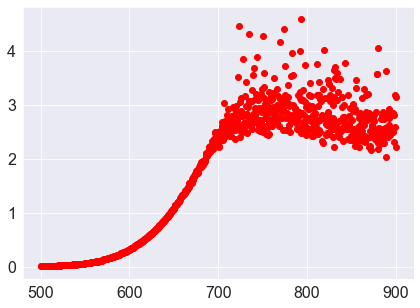

In [9]:
# Fjern outliers for B4
fig, ax = plt.subplots()

dft = dfs_b['B4'].copy()
dft_test = dft[dft.Absorbance !=0] 

ax.scatter(dft_test['Wavelength'],dft_test['Absorbance'],color='r')

plt.show()

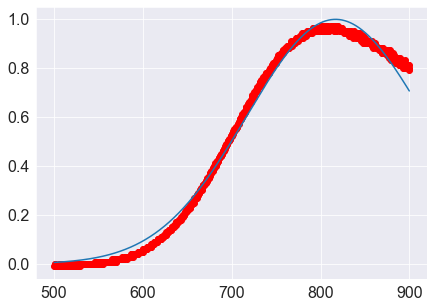

In [10]:
fig, ax = plt.subplots()
def guess(x,a,b,c):
    f = a*np.exp(-((x-b)**2)/(2*c**2))
    return f


start = [100,100,100]
x = pd.Series.to_numpy(dfs_b['B1']['Wavelength'])
y = pd.Series.to_numpy(dfs_b['B1']['Absorbance'])
popt, pcov = sc.curve_fit(guess, x, y, p0=start, absolute_sigma=True)

ax.scatter(dfs_b['B1']['Wavelength'],dfs_b['B1']['Absorbance'],color='r')
ax.plot(x,guess(x, *popt))
plt.show()


811.7349666666668


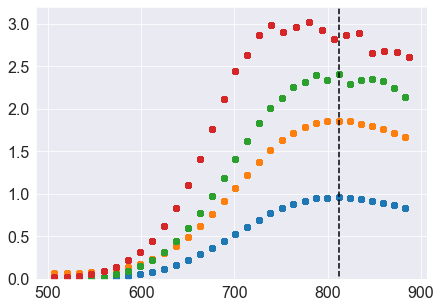

In [11]:
df_1 =  smooth_graph(dfs_b['B1'], threshold=30)
df_2 =  smooth_graph(dfs_b['B2'], threshold=30)
df_3 =  smooth_graph(dfs_b['B3'], threshold=30)
df_4 =  smooth_graph(dft_test, threshold=30)
df_smoothed = [df_1, df_2, df_3, df_4]
  
max_1 = df_1['Absorbance'].max()
lambda_max = df_1.loc[df_1['Absorbance'] == max_1]['Wavelength'].values[0]
print(lambda_max)    

fig, ax = plt.subplots()
for data in df_smoothed:
    ax.scatter(data['Wavelength'],data['Absorbance'])
    
y0 = -1
y1= 4
ax.vlines(lambda_max,y0,y1,ls='--')

ax.set_ylim([0,3.2])
plt.show()

In [12]:
df_smoothed[3]

,Wavelength,Absorbance
0,506.567267,0.018000
1,519.909433,0.023667
2,533.199200,0.037000
3,546.436633,0.058667
4,559.621067,0.092667
...,...,...
28225,833.514333,2.898667
28226,847.155233,2.658667
28227,860.780700,2.686000
28228,874.009567,2.664333


C:\Users\jeppe\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


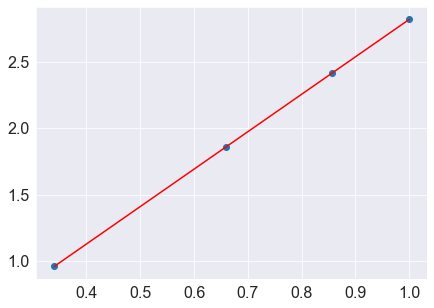

[0.34026956727358704, 0.6590210451643412, 0.8556396311184679, 1.0]

In [13]:
bab_vals = []
for df in df_smoothed:
    bab_vals.append(ab_max(df))
bc_rel = [x/bab_vals[3] for x in bab_vals]




fig, ax = plt.subplots()

x = bc_rel
xs = np.linspace(x[0],x[3],100)
y = bab_vals

def guess(x,a,b):
    f = a*x+b
    return f

start = [0,0]
bpopt, pcov = sc.curve_fit(guess, x, y, p0=start, absolute_sigma=True)

ax.scatter(x,y)
ax.plot(xs,guess(xs,*bpopt),c='r')

plt.show()
bc_rel

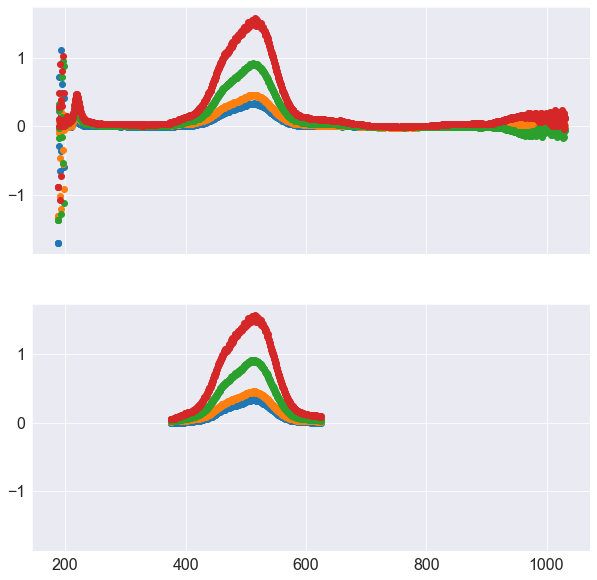

In [14]:
# Rød visualiseres og beskæres
fig, ax = plt.subplots(2,1, sharex=True, sharey=True,figsize=(10,10))


for name in dfs_r:
    ax[0].scatter(dfs_r[name]['Wavelength'],dfs_r[name]['Absorbance'])

filter_rs = []

for name in names_r:
    df1 = dfs_r[name][dfs_r[name]['Wavelength'] > 375]
    df2 = df1[df1['Wavelength'] < 625]
    ax[1].scatter(df2['Wavelength'],df2['Absorbance'])
    filter_rs.append(df2)
    
plt.show()

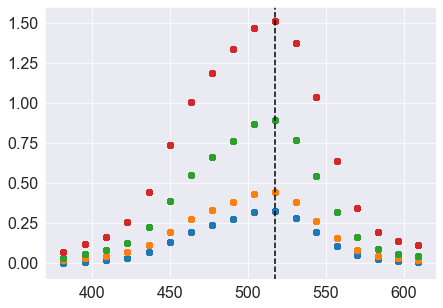

In [15]:
# Rød bliver glattet ud
fig, ax = plt.subplots()

r_smooth = []
rab_vals = []
for df in filter_rs:
    smoothed = smooth_graph(df, 30)
    maxed = ab_max(df)
    ax.scatter(smoothed['Wavelength'],smoothed['Absorbance'])
    r_smooth.append(smoothed)
    rab_vals.append(maxed)
    
max_1 = r_smooth[3]['Absorbance'].max()
lmb =  r_smooth[3].loc[r_smooth[3]['Absorbance'] == max_1]['Wavelength'].values[0]
y0 = -1
y1= 4
ax.vlines(lmb,y0,y1,ls='--')

ax.set_ylim([-0.1,1.6])
plt.show()


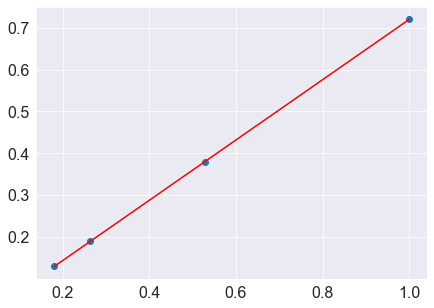

[0.18055555555555558, 0.2638888888888889, 0.5277777777777778, 1.0]

In [16]:
# Relative koncentrationer

rc_rel = [x/rab_vals[3] for x in rab_vals]

fig, ax = plt.subplots()

x = rc_rel
xs = np.linspace(x[0],x[3],100)
y = rab_vals

def guess(x,a,b):
    f = a*x+b
    return f

start = [1,1]
rpopt, pcov = sc.curve_fit(guess, x, y, p0=start, absolute_sigma=True)

ax.scatter(x,y)
ax.plot(xs,guess(xs,*rpopt),c='r')

plt.show()

rc_rel

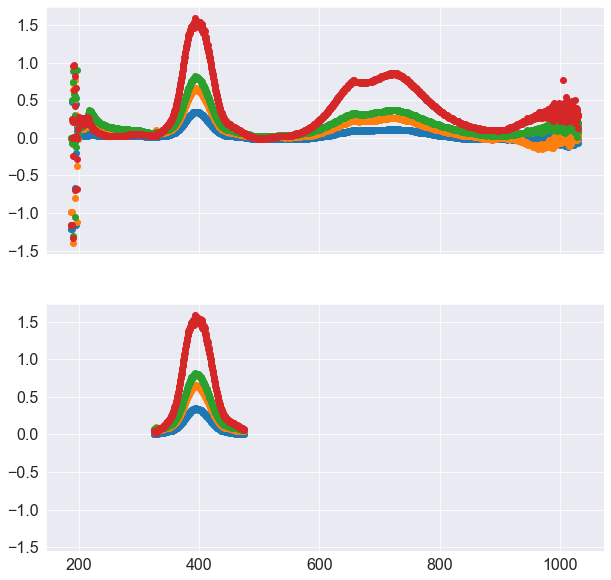

In [17]:
# Grøn visualiseres og beskæres
fig, ax = plt.subplots(2,1, sharex=True, sharey=True,figsize=(10,10))


for name in dfs_g:
    ax[0].scatter(dfs_g[name]['Wavelength'],dfs_g[name]['Absorbance'])

filter_gs = []

for name in names_g:
    df1 = dfs_g[name][dfs_g[name]['Wavelength'] > 325]
    df2 = df1[df1['Wavelength'] < 475]
    ax[1].scatter(df2['Wavelength'],df2['Absorbance'])
    filter_gs.append(df2)
    
plt.show()

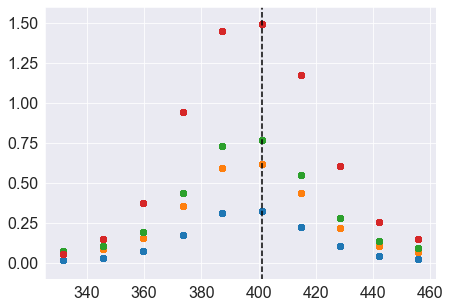

In [18]:
# Rød bliver glattet ud
fig, ax = plt.subplots()

g_smooth = []
gab_vals = []
for df in filter_gs:
    smoothed = smooth_graph(df, 30)
    maxed = ab_max(df)
    ax.scatter(smoothed['Wavelength'],smoothed['Absorbance'])
    g_smooth.append(smoothed)
    gab_vals.append(maxed)
    
max_1 = g_smooth[3]['Absorbance'].max()
lmb =  g_smooth[3].loc[g_smooth[3]['Absorbance'] == max_1]['Wavelength'].values[0]
y0 = -1
y1= 4
ax.vlines(lmb,y0,y1,ls='--')

ax.set_ylim([-0.1,1.6])
plt.show()


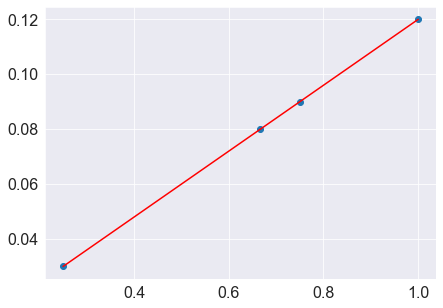

[0.25, 0.6666666666666667, 0.75, 1.0]

In [19]:
# Relative koncentrationer

gc_rel = [x/gab_vals[3] for x in gab_vals]

fig, ax = plt.subplots()

x = gc_rel
xs = np.linspace(x[0],x[3],100)
y = gab_vals

def guess(x,a,b):
    f = a*x+b
    return f

start = [1,1]
gpopt, pcov = sc.curve_fit(guess, x, y, p0=start, absolute_sigma=True)

ax.scatter(x,y)
ax.plot(xs,guess(xs,*gpopt),c='r')

plt.show()

gc_rel

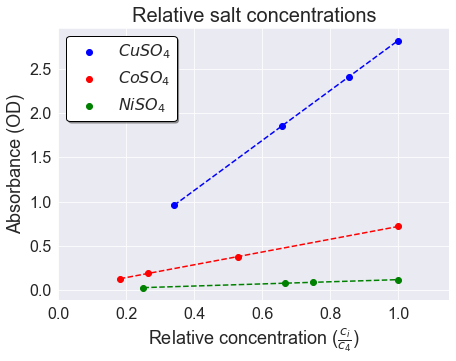

In [20]:
c_rels =[bc_rel,rc_rel,gc_rel]
ab_vals = [bab_vals,rab_vals,gab_vals]
popts = [bpopt,rpopt,gpopt]
colours = ['b','r','g']
names = [r'$CuSO_4$',r'$CoSO_4$',r'$NiSO_4$']

def guess(x,a,b):
    f = a*x+b
    return f

# Definer en stor figur
fig, ax = plt.subplots()


for x,y,p,col,nm in zip(c_rels,ab_vals,popts,colours,names):
    xs = np.linspace(x[0],x[3],100)
    ax.scatter(x,y,color=col,label=nm)
    ax.plot(xs,guess(xs,*p),color=col, ls='--',)
    
ax.set_title('Relative salt concentrations')
ax.set_xlabel(r'Relative concentration ($\frac{c_i}{c_4}$)')
ax.set_ylabel('Absorbance (OD)')
ax.set_xlim([0,1.15])
ax.legend(facecolor='white', edgecolor='black', shadow=True)
plt.savefig(fname=f'../../../Final_graphs/Rel_conc.pdf',format='pdf')
plt.show()
